https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-okrur6f5
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-okrur6f5
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00ta 0:00:01
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/70/a9/a9f63dde69ac5a4451d8a0ebdde95824ec31aafcae1c77658a9058e27bb7/scikit_image-0.21.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.9.1 from https://files.pythonhosted.org/packages/71/3c/3b1981c6a1986adc9ee7db760c0c34ea5b14ac3da9ecfcf1ea2a4ec6c398/numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator

MASK_COLORS = [
    "red", "green", "blue",
    "yellow", "magenta", "cyan"
]


# Runtime data augmentation
def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    s=10,
    data_gen_args=dict(
        rotation_range=10.0,
        # width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        # zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):
    """[summary]
    
    Args:
        X_train (numpy.ndarray): [description]
        Y_train (numpy.ndarray): [description]
        X_val (numpy.ndarray, optional): [description]. Defaults to None.
        Y_val (numpy.ndarray, optional): [description]. Defaults to None.
        batch_size (int, optional): [description]. Defaults to 32.
        seed (int, optional): [description]. Defaults to 0.
        data_gen_args ([type], optional): [description]. Defaults to dict(rotation_range=10.0,# width_shift_range=0.02,height_shift_range=0.02,shear_range=5,# zoom_range=0.3,horizontal_flip=True,vertical_flip=False,fill_mode="constant",).
    
    Returns:
        [type]: [description]
    """

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=s)
    Y_datagen.fit(Y_train, augment=True, seed=s)
    X_train_augmented = X_datagen.flow(
        X_train, batch_size=batch_size, shuffle=True, seed=s
    )
    Y_train_augmented = Y_datagen.flow(
        Y_train, batch_size=batch_size, shuffle=True, seed=s
    )

    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=False, seed=s)
        Y_datagen_val.fit(Y_val, augment=False, seed=s)
        X_val_augmented = X_datagen_val.flow(
            X_val, batch_size=batch_size, shuffle=False, seed=s
        )
        Y_val_augmented = Y_datagen_val.flow(
            Y_val, batch_size=batch_size, shuffle=False, seed=s
        )

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    else:
        return train_generator


def plot_segm_history(history, metrics=["iou", "val_iou"], losses=["loss", "val_loss"]):
    """[summary]
    
    Args:
        history ([type]): [description]
        metrics (list, optional): [description]. Defaults to ["iou", "val_iou"].
        losses (list, optional): [description]. Defaults to ["loss", "val_loss"].
    """
    # summarize history for iou
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()


def mask_to_red(mask):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    img_size = mask.shape[0]
    c1 = mask.reshape(img_size, img_size)
    c2 = np.zeros((img_size, img_size))
    c3 = np.zeros((img_size, img_size))
    c4 = mask.reshape(img_size, img_size)
    return np.stack((c1, c2, c3, c4), axis=-1)


def mask_to_rgba(mask, color="red"):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
        color (str, optional): Check `MASK_COLORS` for available colors. Defaults to "red".
    
    Returns:
        numpy.ndarray: [description]
    """    
    assert(color in MASK_COLORS)
    assert(mask.ndim==3 or mask.ndim==2)

    h = mask.shape[0]
    w = mask.shape[1]
    zeros = np.zeros((h, w))
    ones = mask.reshape(h, w)
    if color == "red":
        return np.stack((ones, zeros, zeros, ones), axis=-1)
    elif color == "green":
        return np.stack((zeros, ones, zeros, ones), axis=-1)
    elif color == "blue":
        return np.stack((zeros, zeros, ones, ones), axis=-1)
    elif color == "yellow":
        return np.stack((ones, ones, zeros, ones), axis=-1)
    elif color == "magenta":
        return np.stack((ones, zeros, ones, ones), axis=-1)
    elif color == "cyan":
        return np.stack((zeros, ones, ones, ones), axis=-1)


def plot_imgs(
        org_imgs,
        mask_imgs,
        pred_imgs=None,
        nm_img_to_plot=10,
        figsize=4,
        alpha=0.5,
        color="red"):
    """
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    Args:
        org_imgs (numpy.ndarray): Array of arrays representing a collection of original images.
        mask_imgs (numpy.ndarray): Array of arrays representing a collection of mask images (grayscale).
        pred_imgs (numpy.ndarray, optional): Array of arrays representing a collection of prediction masks images.. Defaults to None.
        nm_img_to_plot (int, optional): How many images to display. Takes first N images. Defaults to 10.
        figsize (int, optional): Matplotlib figsize. Defaults to 4.
        alpha (float, optional): Transparency for mask overlay on original image. Defaults to 0.5.
        color (str, optional): Color for mask overlay. Defaults to "red".
    """ # NOQA E501
    assert(color in MASK_COLORS)

    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

    fig, axes = plt.subplots(
        nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize), squeeze=False
    )
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(
                mask_to_rgba(
                    zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(pred_imgs),
                alpha=alpha,
            )
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(
                mask_to_rgba(
                    zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(mask_imgs),
                alpha=alpha,
            )
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()


def zero_pad_mask(mask, desired_size):
    """[summary]
    
    Args:
        mask (numpy.ndarray): [description]
        desired_size ([type]): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask


def reshape_arr(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])


def get_cmap(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        string: [description]
    """
    if arr.ndim == 3:
        return "gray"
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return "jet"
        elif arr.shape[3] == 1:
            return "gray"


def get_patches(img_arr, size=256, stride=256):
    """
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    
    Args:
        img_arr (numpy.ndarray): [description]
        size (int, optional): [description]. Defaults to 256.
        stride (int, optional): [description]. Defaults to 256.
    
    Raises:
        ValueError: [description]
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """    
    # check size and stride
    if size % stride != 0:
        raise ValueError("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping

        for i in range(i_max):
            for j in range(i_max):
                # print(i*stride, i*stride+size)
                # print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size
                    ]
                )

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    # print(i*stride, i*stride+size)
                    # print(j*stride, j*stride+size)
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        raise ValueError("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)


def plot_patches(img_arr, org_img_size, stride=None, size=None):
    """
    Plots all the patches for the first image in 'img_arr' trying to reconstruct the original image
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    Raises:
        ValueError: [description]
    """

    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    fig, axes = plt.subplots(i_max, j_max, figsize=(i_max * 2, j_max * 2))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    jj = 0
    for i in range(i_max):
        for j in range(j_max):
            axes[i, j].imshow(img_arr[jj])
            axes[i, j].set_axis_off()
            jj += 1


def reconstruct_from_patches(img_arr, org_img_size, stride=None, size=None):
    """[summary]
    
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    
    Raises:
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    nm_layers = img_arr.shape[3]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    total_nm_images = img_arr.shape[0] // (i_max ** 2)
    nm_images = img_arr.shape[0]

    averaging_value = size // stride
    images_list = []
    kk = 0
    for img_count in range(total_nm_images):
        img_bg = np.zeros(
            (org_img_size[0], org_img_size[1], nm_layers), dtype=img_arr[0].dtype
        )

        for i in range(i_max):
            for j in range(j_max):
                for layer in range(nm_layers):
                    img_bg[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size,
                        layer,
                    ] = img_arr[kk, :, :, layer]

                kk += 1
        # TODO add averaging for masks - right now it's just overwritting

        #         for layer in range(nm_layers):
        #             # average some more because overlapping 4 patches
        #             img_bg[stride:i_max*stride, stride:i_max*stride, layer] //= averaging_value
        #             # corners:
        #             img_bg[0:stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value
        #             img_bg[0:stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value

        images_list.append(img_bg)

    return np.stack(images_list)

ModuleNotFoundError: No module named 'tensorflow'

### dicom_reader.py

In [1]:
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def apply_window(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_width, window_level):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = apply_window(image_hu.copy(), window_level, window_width)
    image_window_norm = resize_normalize(image_window)

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

### rle_encode.py

In [2]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

# EDA

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/fds/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


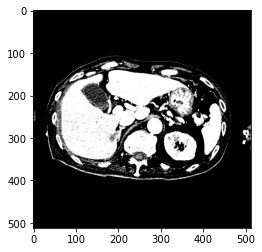

In [3]:
import matplotlib.pylab as plt

# specify your image path
image_path = "./train/dcm/case001.dcm"
im = read_dicom(image_path, 100, 50)
%pylab inline
imgplot = plt.imshow(im)
plt.show()

(array([575385.,  10962.,  11985.,   9336.,   9585.,   9096.,   6900.,
          5823.,   8037., 139323.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

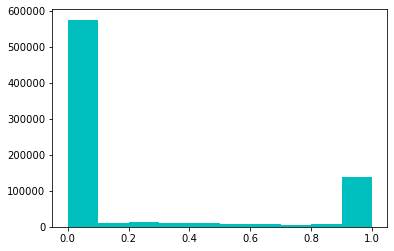

In [4]:
plt.hist(im.flatten(), color='c')

In [5]:
np.unique(im)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [6]:
import cv2
import pydicom
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [7]:
im = mpimg.imread("./train/label/case003.png")
unique, counts = np.unique(im, return_counts=True)
dict(zip(unique, counts))

{0.0: 159566, 0.003921569: 72640, 0.007843138: 15781, 0.011764706: 14157}

In [8]:
np.unique(im)

array([0.        , 0.00392157, 0.00784314, 0.01176471], dtype=float32)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/fds/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['unique']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


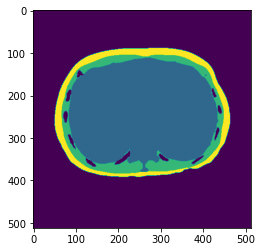

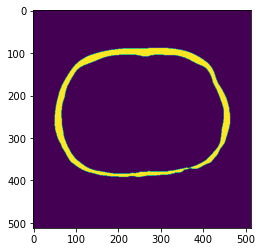

In [9]:
im = mpimg.imread("./train/label/case003.png")
im = np.around(im, 8)
mask_1 = im <= 0.007843138
mask_2 = im >= 0.011764706

mask_3 = np.logical_and(mask_1, mask_2)
mask_3
# im = np.expand_dims(im, axis=-1)
%pylab inline
imgplot = plt.imshow(im)
plt.show()
mask_3_int = mask_2.astype(float)
imgplot = plt.imshow(mask_3_int)
plt.show()
# https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb

In [10]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH_IMAGE = './train/dcm/'
TRAIN_PATH_MASKS = './train/label/'
TEST_PATH = './test/dcm/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [11]:
# Get train and test IDs
train_ids = [f for f in sorted(os.listdir(TRAIN_PATH_IMAGE)) if os.path.isfile(os.path.join(TRAIN_PATH_IMAGE, f))]
test_ids = [f for f in sorted(os.listdir(TEST_PATH)) if os.path.isfile(os.path.join(TEST_PATH, f))]

In [12]:
def get_mask_innest(mask):
    mask_1 = mask < 0.007843138
    mask_2 = mask >= 0.003921569
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_3.astype(float)
    return mask_3_int

def get_mask_middle(mask):
    mask_1 = mask < 0.011764706
    mask_2 = mask >= 0.007843138
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_3.astype(float)
    return mask_3_int

def get_mask_outtest(mask):
    mask_1 = mask < 0.011764706
    mask_2 = mask >= 0.011764706
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_2.astype(float)
    return mask_3_int
# {0.0: 159566, 0.003921569: 72640, 0.007843138: 15781, 0.011764706: 14157}

In [13]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
print('Getting and resizing train images and masks')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if id_ == 'case001.dcm':
        print(n)
    path = TRAIN_PATH_IMAGE + id_
    img = read_dicom(path, 100, 50)
    X_train[n] = img
    mask_path = TRAIN_PATH_MASKS + id_.replace('dcm', 'png')
    mask = mpimg.imread(mask_path)
    mask = np.around(mask, 8)

    m_in = get_mask_innest(mask)
    m_md = get_mask_middle(mask)
    m_ot = get_mask_outtest(mask)
    
    m_in = np.expand_dims(m_in, axis=-1)
    m_md = np.expand_dims(m_md, axis=-1)
    m_ot = np.expand_dims(m_ot, axis=-1)
    
    m_fn = np.concatenate([m_in, m_md, m_ot], axis=-1)
    
    Y_train[n] = m_fn

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = read_dicom(path, 100, 50)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks


  4%|▍         | 4/100 [00:00<00:02, 39.78it/s]

0


100%|██████████| 100/100 [00:01<00:00, 50.10it/s]

Getting and resizing test images ... 



100%|██████████| 50/50 [00:00<00:00, 94.48it/s] 

Done!


In [14]:
# from sklearn.model_selection import train_test_split

# x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

# print("x_train: ", x_train.shape)
# print("y_train: ", y_train.shape)
# print("x_val: ", x_val.shape)
# print("y_val: ", y_val.shape)

In [23]:
import cv2
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

class MyCoolDataset(Dataset):

    def __init__(self, train=True, transforms=None):
        # all your data loading logic using cv2, glob ..
        self.transforms = transforms
        x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=4)
        
        # two modes - train and test
        if train:
            self.x_data, self.y_data = x_train, y_train
        else:
            self.x_data, self.y_data = x_test, y_test
    
    def __getitem__(self, i):
        x = self.x_data[i] 
        y = self.y_data[i]

        # result = {"image": x}
        # result["mask"] = y
        if self.transforms is not None:
            # result = self.transforms(**result)
            x = self.transforms(x)
            y = self.transforms(y)

        # return result
        return x, y


    def __len__(self):
        return len(self.y_data)

In [24]:
from torchvision import transforms
train_preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
val_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(MyCoolDataset(True,train_preprocess), batch_size=2, shuffle=True, num_workers=8)
valid_dataloader = DataLoader(MyCoolDataset(False,val_preprocess), batch_size=2, shuffle=False, num_workers=8)

In [26]:
train_dataloader

In [32]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

import torch.nn.functional as F

In [33]:
class MorphometryModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # # Shape of the image should be (batch_size, num_channels, height, width)
        # # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        # assert image.ndim == 4

        # # Check that image dimensions are divisible by 32, 
        # # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # # and we will get an error trying to concat these features
        # h, w = image.shape[2:]
        # assert h % 32 == 0 and w % 32 == 0

        # mask = batch["mask"]

        # # Shape of the mask should be [batch_size, num_classes, height, width]
        # # for binary segmentation num_classes = 1
        # assert mask.ndim == 4

        # # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        # assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = F.softmax(logits_mask, dim=1)
        # pred_mask = (prob_mask > 0.5).float()
        pred_mask = (prob_mask).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [34]:
model = MorphometryModel("Unet", "efficientnet-b5", in_channels=3, out_classes=3)

In [36]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 31.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
31.2 M    Trainable params
0         Non-trainable params
31.2 M    Total params
124.865   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_1962280/4117535082.py", line 29, in __getitem__
    x = self.transforms(x)
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 94, in __call__
    img = t(img)
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 739, in forward
    return F.vflip(img)
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 706, in vflip
    return F_pil.vflip(img)
  File "/home/fds/miniconda3/envs/py310_pytorch/lib/python3.10/site-packages/torchvision/transforms/functional_pil.py", line 64, in vflip
    raise TypeError(f"img should be PIL Image. Got {type(img)}")
TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>


# Import

In [ ]:
for i in sys.path:
    print(i)

In [ ]:
"""Train
"""
from datetime import datetime
from time import time
import numpy as np
import shutil, random, os, sys, torch
from glob import glob

# prj_dir = os.path.dirname(os.path.abspath(__file__)) # for script
prj_dir = os.path.dirname(os.path.abspath("")) # for jupyter
sys.path.append(prj_dir)

from modules.utils import load_yaml, get_logger
from modules.metrics import get_metric_function
from modules.earlystoppers import EarlyStopper
from modules.losses import get_loss_function
from modules.optimizers import get_optimizer
from modules.schedulers import get_scheduler
from modules.scalers import get_image_scaler
from modules.datasets import SegDataset
from modules.recorders import Recorder
from modules.trainer import Trainer
from models.utils import get_model

ModuleNotFoundError: No module named 'modules'

In [ ]:
prj_dir = os.path.abspath("")

In [ ]:
prj_dir

'/home/fds/Dev/Python/2022_AI_competition/Body Morphometry A.I. Segmentation'

In [ ]:
yaml = 'train.yaml'

# Configs

In [ ]:

# Load config
config_path = os.path.join(prj_dir, 'config', yaml)
config = load_yaml(config_path)

# Set train serial: ex) 20211004
train_serial = datetime.now().strftime("%Y%m%d_%H%M%S")
train_serial = 'debug' if config['debug'] else train_serial

# Set random seed, deterministic
torch.cuda.manual_seed(config['seed'])
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
random.seed(config['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device(GPU/CPU)
os.environ['CUDA_VISIBLE_DEVICES'] = str(config['gpu_num'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create train result directory and set logger
train_result_dir = os.path.join(prj_dir, 'results', 'train', config['architecture'], train_serial)
os.makedirs(train_result_dir, exist_ok=True)

# Set logger
logging_level = 'debug' if config['verbose'] else 'info'
logger = get_logger(name='train',
                    file_path=os.path.join(train_result_dir, 'train.log'),
                    level=logging_level)


# Set data directory
train_dirs = os.path.join(prj_dir, 'data', 'train')

# Model

In [ ]:
# Load model
model = get_model(model_str=config['architecture'])
model = model(classes=config['n_classes'],
            encoder_name=config['encoder'],
            encoder_weights=config['encoder_weight'],
            activation=config['activation']).to(device)
logger.info(f"Load model architecture: {config['architecture']}")

# Set optimizer
optimizer = get_optimizer(optimizer_str=config['optimizer']['name'])
optimizer = optimizer(model.parameters(), **config['optimizer']['args'])

# Set Scheduler
scheduler = get_scheduler(scheduler_str=config['scheduler']['name'])
scheduler = scheduler(optimizer=optimizer, **config['scheduler']['args'])

# Set loss function
loss_func = get_loss_function(loss_function_str=config['loss']['name'])
loss_func = loss_func(**config['loss']['args'])

# Set metric
metric_funcs = {metric_name:get_metric_function(metric_name) for metric_name in config['metrics']}
logger.info(f"Load optimizer:{config['optimizer']['name']}, scheduler: {config['scheduler']['name']}, loss: {config['loss']['name']}, metric: {config['metrics']}")

# Set trainer
trainer = Trainer(model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_func=loss_func,
                metric_funcs=metric_funcs,
                device=device,
                logger=logger)
logger.info(f"Load trainer")

# Set early stopper
early_stopper = EarlyStopper(patience=config['earlystopping_patience'],
                            logger=logger)
# Set recorder
recorder = Recorder(record_dir=train_result_dir,
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    logger=logger)
logger.info("Load early stopper, recorder")

# Recorder - save train config
shutil.copy(config_path, os.path.join(recorder.record_dir, yaml))


# Train

In [ ]:
# Train
print("START TRAINING")
logger.info("START TRAINING")
for epoch_id in range(config['n_epochs']):
    
    # Initiate result row
    row = dict()
    row['epoch_id'] = epoch_id
    row['train_serial'] = train_serial
    row['lr'] = trainer.scheduler.get_last_lr()

    # Train
    print(f"Epoch {epoch_id}/{config['n_epochs']} Train..")
    logger.info(f"Epoch {epoch_id}/{config['n_epochs']} Train..")
    tic = time()
    trainer.train(dataloader=train_dataloader, epoch_index=epoch_id)
    toc = time()
    # Write tarin result to result row
    row['train_loss'] = trainer.loss  # Loss
    for metric_name, metric_score in trainer.scores.items():
        row[f'train_{metric_name}'] = metric_score

    row['train_elapsed_time'] = round(toc-tic, 1)
    # Clear
    trainer.clear_history()

    # Validation
    print(f"Epoch {epoch_id}/{config['n_epochs']} Validation..")
    logger.info(f"Epoch {epoch_id}/{config['n_epochs']} Validation..")
    tic = time()
    trainer.validate(dataloader=valid_dataloader, epoch_index=epoch_id)
    toc = time()
    row['val_loss'] = trainer.loss
    # row[f"val_{config['metric']}"] = trainer.score
    for metric_name, metric_score in trainer.scores.items():
        row[f'val_{metric_name}'] = metric_score
    row['val_elapsed_time'] = round(toc-tic, 1)
    trainer.clear_history()

    # Performance record - row
    recorder.add_row(row)
    
    # Performance record - plot
    recorder.save_plot(config['plot'])

    # Check early stopping
    early_stopper.check_early_stopping(row[config['earlystopping_target']])
    if early_stopper.patience_counter == 0:
        recorder.save_weight(epoch=epoch_id)
        
    if early_stopper.stop:
        print(f"Epoch {epoch_id}/{config['n_epochs']}, Stopped counter {early_stopper.patience_counter}/{config['earlystopping_patience']}")
        logger.info(f"Epoch {epoch_id}/{config['n_epochs']}, Stopped counter {early_stopper.patience_counter}/{config['earlystopping_patience']}")
        break

print("END TRAINING")
logger.info("END TRAINING")